# WDSR

In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

from data import DIV2K
from model.srgan import SrGan, CustomCallback

%matplotlib inline

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
def show_current_time():
    current_time = datetime.now().strftime("%D %H:%M:%S")
    print(current_time)

In [4]:
# activate GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')

        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

# number of steps
steps = 100000

In [6]:
# Location of model weights (needed for demo)
weights_dir = f'weights/srgan-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [7]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [8]:
train_ds = div2k_train.dataset(batch_size=1, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [9]:
srgan = SrGan(scale=scale, 
             checkpoint_dir=f'.ckpt/srgan-{depth}-x{scale}',
             valid_ds=valid_ds.take(10),
             steps=steps)

srgan.compile()

Model restored from checkpoint at step <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=111000>.


In [10]:
show_current_time()

01/16/21 19:19:14


In [11]:
# number_of_epochs = (steps - srgan.checkpoint.step).numpy()
# print('Number 0f steps:', number_of_steps)

srgan.fit(train_ds.take(1000), epochs=100, callbacks=[CustomCallback()])

Epoch 1/100
1000/1000 [==============================] - 11s 11ms/step - c_loss: 7.6938
Epoch 2/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.9194: 7.919, PSNR: 25.09
Epoch 3/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.6989: 7.704, PSNR: 28.44
Epoch 4/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.4413: 7.444, PSNR: 27.04
Epoch 5/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.6213: 7.626, PSNR: 28.10
Epoch 6/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.3637: 7.367, PSNR: 27.66
Epoch 7/100
1000/1000 [==============================] - 11s 11ms/step - c_loss: 7.7403: 7.745, PSNR: 28.30
Epoch 8/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.1872ss: 7.192, PSNR: 28.33
Epoch 9/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 8.1987: 8.205, PSNR: 28.18
Epoch 10/100
1000/1000 [======================

Epoch 73/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.5416: 7.540, PSNR: 28.44
Epoch 74/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.3748: 7.380, PSNR: 28.63
Epoch 75/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.6083: 7.614, PSNR: 28.50
Epoch 76/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 11.6476: 11.656, PSNR: 26.7
Epoch 77/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.7903: 7.795, PSNR: 27.46
Epoch 78/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.4121: 7.412, PSNR: 28.30
Epoch 79/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.5501: 7.548, PSNR: 26.65
Epoch 80/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.6594: 7.664, PSNR: 27.36
Epoch 81/100
1000/1000 [==============================] - 10s 10ms/step - c_loss: 7.4734: 7.477, PSNR: 27.71
Epoch 82/100
1000/

In [12]:
show_current_time()

01/16/21 19:36:36


In [13]:
# Restore from checkpoint with highest PSNR
srgan.restore()

Model restored from checkpoint at step <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=207000>.


In [14]:
# Evaluate model on full validation set
psnr = srgan.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 28.086769


In [15]:
# Save weights to separate location (needed for demo)
srgan.model.save_weights(weights_file)

## Demo

In [16]:
# model = srgan(scale=scale, num_res_blocks=depth)
# model.load_weights(weights_file)

In [23]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(srgan.model, lr)
    plot_sample(lr, sr)

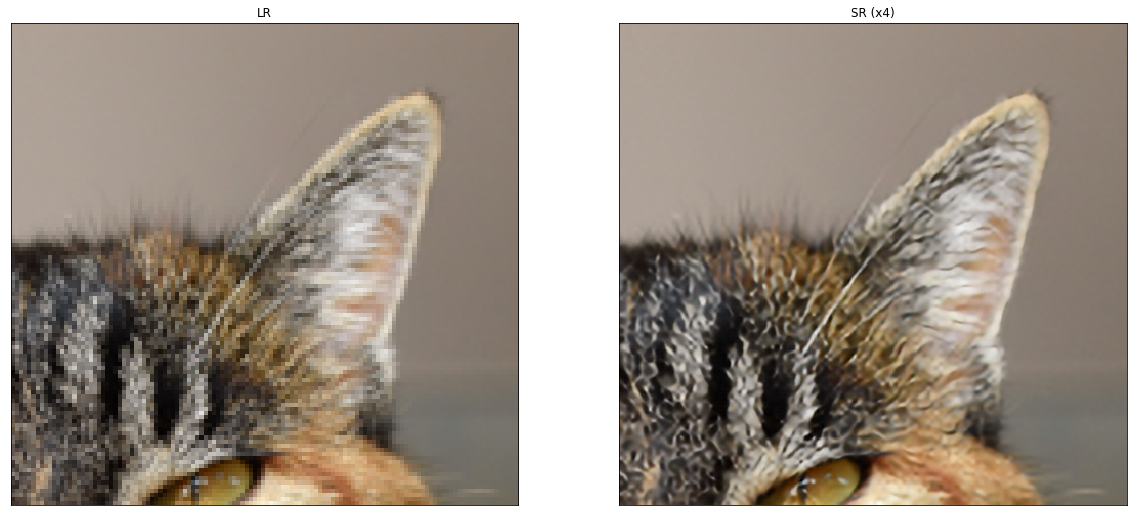

In [24]:
resolve_and_plot('demo/0869x4-crop.png')

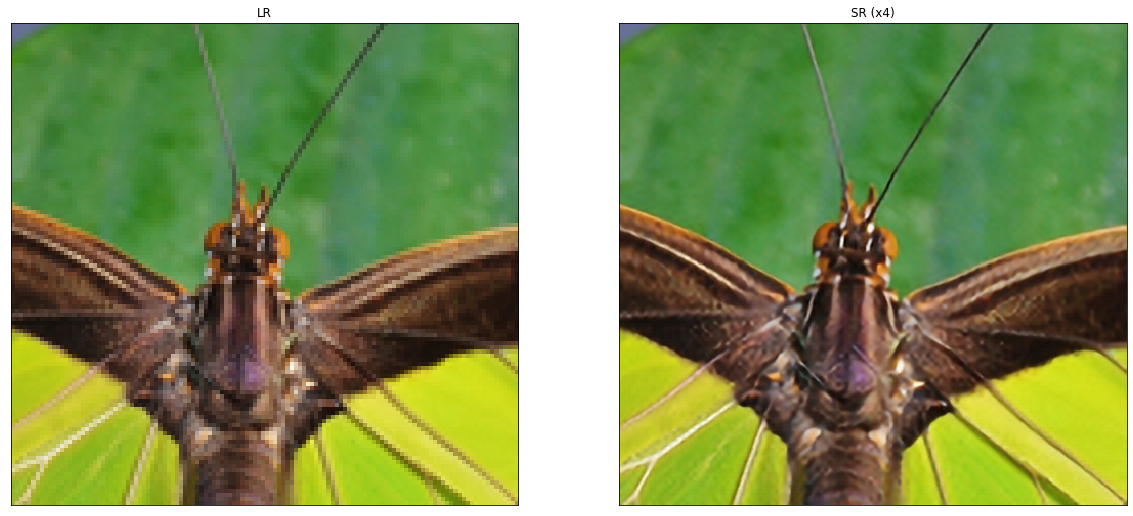

In [25]:
resolve_and_plot('demo/0829x4-crop.png')

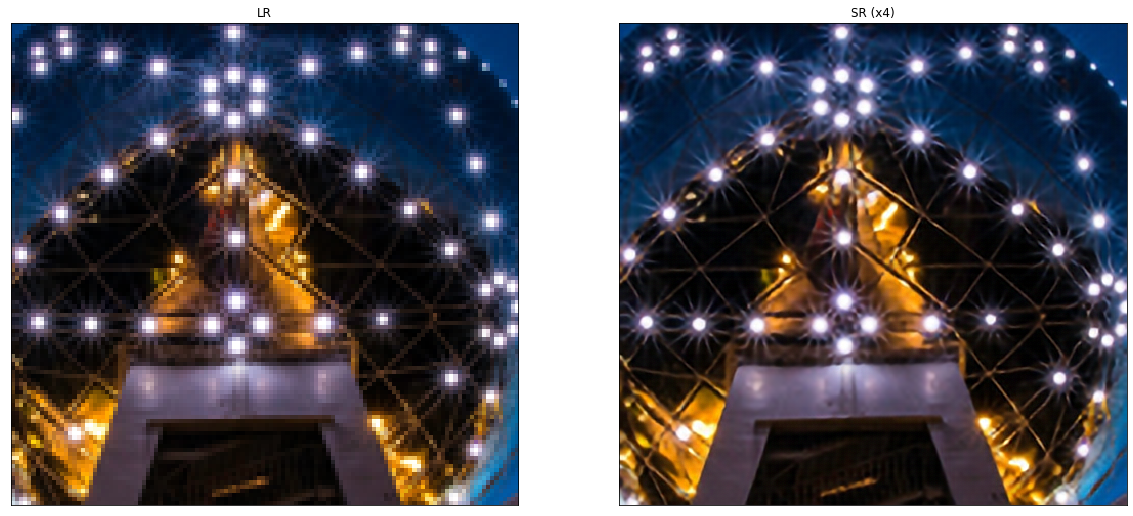

In [26]:
resolve_and_plot('demo/0851x4-crop.png')

In [21]:
# weights_dir_a = f'weights/wdsr-a-{32}-x{scale}'
# weights_file_a = os.path.join(weights_dir_a, 'weights.h5')

# model_a = wdsr_a(scale=scale, num_res_blocks=32)
# model_a.load_weights(weights_file_a)



# weights_dir_b = f'weights/wdsr-b-{32}-x{scale}'
# weights_file_b = os.path.join(weights_dir_b, 'weights.h5')

# model_b = wdsr_b(scale=scale, num_res_blocks=32)
# model_b.load_weights(weights_file_b)



# weights_dir_b_16 = f'weights/wdsr-b-{16}-x{scale}'
# weights_file_b_16 = os.path.join(weights_dir_b_16, 'weights.h5')

# model_b_16 = wdsr_b(scale=scale, num_res_blocks=16)
# model_b_16.load_weights(weights_file_b_16)


# def resolve_and_plot(model, lr_image_path):
#     lr = load_image(lr_image_path)
#     sr = resolve_single(model, lr)
#     plot_sample(lr, sr)

In [22]:
# resolve_and_plot(model_a, 'demo/0851x4-crop.png')
# resolve_and_plot(model_b, 'demo/0851x4-crop.png')
# resolve_and_plot(model_b_16, 'demo/0851x4-crop.png')